<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install prophet

In [2]:
# !pip install python-bcb

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('../../data library/Milho_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df.head()

ds Cultivo        y     País  Id   Último  Abertura   Máxima  \
0  2004-03-01   Milho  16.9936  17.5722   1  32025.0   32500.0  34200.0   
1  2004-04-01   Milho  19.8861  19.4868   1  29975.0   32125.0  32650.0   
2  2004-05-01   Milho  19.7989  20.2459   1  26250.0   30500.0  32250.0   
3  2004-06-01   Milho  17.9299  19.0091   1  22550.0   26250.0  26425.0   
4  2004-07-01   Milho  16.4940  17.7122   1  23775.0   22550.0  24525.0   

    Mínima  
0  30300.0  
1  28175.0  
2  26000.0  
3  22500.0  
4  22500.0

In [5]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [6]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

Data Medicao precipitacao temperatura
0   31/03/2004        175.4        24.9
1   30/04/2004        175.4        24.5
2   31/05/2004           23        21.7
3   30/06/2004         18.8        22.1
4   31/07/2004           38        22.2

In [7]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

ds Cultivo        y     País  Id   Último  Abertura   Máxima  \
0  2004-03-01   Milho  16.9936  17.5722   1  32025.0   32500.0  34200.0   
1  2004-04-01   Milho  19.8861  19.4868   1  29975.0   32125.0  32650.0   
2  2004-05-01   Milho  19.7989  20.2459   1  26250.0   30500.0  32250.0   
3  2004-06-01   Milho  17.9299  19.0091   1  22550.0   26250.0  26425.0   
4  2004-07-01   Milho  16.4940  17.7122   1  23775.0   22550.0  24525.0   

    Mínima       USD  Precipitacao  Temperatura  lag_Estadual  
0  30300.0  2.905457         175.4         24.9       16.9936  
1  28175.0  2.905985         175.4         24.5       16.9936  
2  26000.0  3.100419          23.0         21.7       19.8861  
3  22500.0  3.129148          18.8         22.1       19.7989  
4  22500.0  3.036777          38.0         22.2       17.9299

In [8]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [9]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [10]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [11]:
m = Prophet()
m.fit(train)

# m.params

00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2020-08-01  32.820704   27.652948   38.486351
1 2020-09-01  33.057574   27.780150   38.008425
2 2020-10-01  33.678613   28.539628   38.694901
3 2020-11-01  34.231653   29.048003   39.176947
4 2020-12-01  34.677746   29.431488   39.949106

In [13]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

ds        y       yhat
0  2020-08-01  45.2704  32.820704
1  2020-09-01  50.0149  33.057574
2  2020-10-01  57.2360  33.678613
3  2020-11-01  67.7848  34.231653
4  2020-12-01  64.7903  34.677746

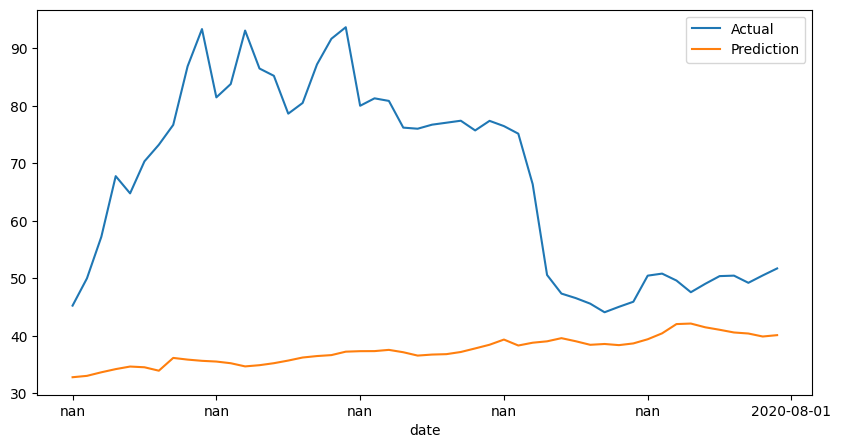

MAE: 29.951625112634886
RMSE: 34.741628763565444
MAPE: 0.40344711208503226
R-Squared: -3.5438804314488452


In [14]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

# Multivariado

In [15]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

00:08:45 - cmdstanpy - INFO - Chain [1] start processing
00:08:45 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

ds       USD     País   Último   Máxima  lag_Estadual
0  2020-08-01  5.280191  45.8405  34850.0  35300.0       41.5048
1  2020-09-01  5.461233  51.5842  37900.0  38275.0       45.2704
2  2020-10-01  5.399486  60.4194  39850.0  42225.0       50.0149
3  2020-11-01  5.625790  72.0206  41975.0  43050.0       57.2360
4  2020-12-01  5.417835  69.2060  48400.0  48575.0       67.7848

In [17]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [18]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2020-08-01  43.898755   42.881202   44.985233
1 2020-09-01  48.638258   47.570950   49.685441
2 2020-10-01  56.224268   55.158816   57.242876
3 2020-11-01  66.381662   65.369536   67.464686
4 2020-12-01  64.355238   63.362962   65.380782

In [19]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

ds        y     País       USD       yhat
0  2020-08-01  45.2704  45.8405  5.280191  43.898755
1  2020-09-01  50.0149  51.5842  5.461233  48.638258
2  2020-10-01  57.2360  60.4194  5.399486  56.224268
3  2020-11-01  67.7848  72.0206  5.625790  66.381662
4  2020-12-01  64.7903  69.2060  5.417835  64.355238

In [20]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

MAE: 4.084164893567509
RMSE: 5.1255908538767345
MAPE: 0.054579883229353546
R-Squared: 0.9010958724602306
